In [1]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [2]:
## defining a frame for image and mask storage
frameObjTrain = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split('_')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+'_t.png')
        maskNames.append(unames[i]+'_i2.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj


frameObjTrain = LoadData( frameObjTrain, imgPath = 'D:/Terrain Mapping/terrain maps'
                        , maskPath = 'D:/Terrain Mapping/segementation maps'
                         , shape = 128)

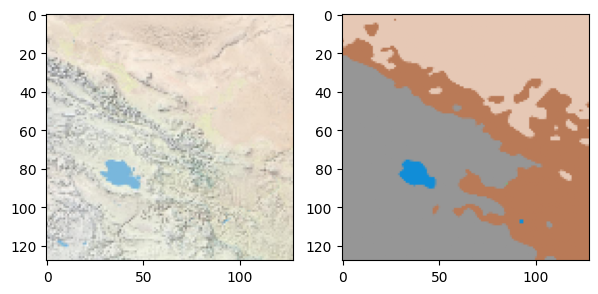

In [3]:
## displaying data loaded by our function
plt.figure(figsize = (7, 5))
plt.subplot(1,2,1)
plt.imshow(frameObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(frameObjTrain['mask'][1])
plt.show()

In [4]:
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [5]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2.0 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


In [6]:
# Instantiate model with Dice loss and Dice coefficient as parameters
inputs = tf.keras.layers.Input((128, 128, 3))
myTransformer = GiveMeUnet(inputs, droupouts=0.07)

# Compile the model with the custom loss and metrics
myTransformer.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[dice_coefficient])

# Train the model as before
retVal = myTransformer.fit(np.array(frameObjTrain['img']), 
                           np.array(frameObjTrain['mask']), epochs=50, verbose=0)

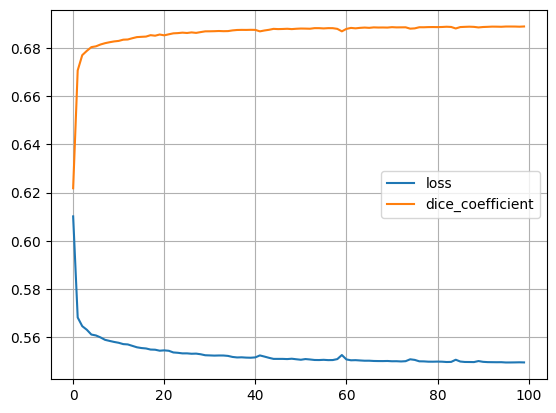

In [7]:
plt.plot(retVal.history['loss'], label='loss')
plt.plot(retVal.history['dice_coefficient'], label='dice_coefficient')
plt.legend()
plt.grid(True)

In [10]:
# Create a folder to save the images if it doesn't exist
output_folder = 'output_images'
os.makedirs(output_folder, exist_ok=True)

## function for getting predictions
def predict (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc


def Plotter(img, predMask, index = 0):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Terrain Image')
    plt.axis('off')
    
    ## Adding Image sharpening step here
    filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) 
    imgSharpen = cv2.filter2D(predMask,-1,filter)
    
    plt.subplot(1,2,2)
    plt.imshow(predMask)
    plt.title('Predicted Terrain Mask')
    plt.axis('off')

    # Save the image
    save_path = os.path.join(output_folder, f'output_{index}.png')
    plt.savefig(save_path)
    plt.close()

In [11]:
# Generate and save 1000 images
Prediction, actuals = predict(frameObjTrain, myTransformer)
for i in range(len(actuals)):
    Plotter(actuals[i], Prediction[i], i)

125/125 [==============================] - 3s 20ms/step


In [ ]:
Prediction, actuals = predict(frameObjTrain, myTransformer)
Plotter(actuals[1], Prediction[1])

In [ ]:
Plotter(actuals[2], Prediction[2])

In [ ]:
Plotter(actuals[3], Prediction[3])

In [ ]:
Plotter(actuals[4], Prediction[4])

In [ ]:
Plotter(actuals[5], Prediction[5])

In [ ]:
myTransformer.save('TerrainMaskGenerator.h5')